In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_theme(font_scale=2.5) 
# 이 두줄은 본 필자가 항상 쓰는 방법입니다. 
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno


%matplotlib inline

In [2]:
import os
for dirname, _, filenames in os.walk('C:/titanic/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/titanic/kaggle/input\gender_submission.csv
C:/titanic/kaggle/input\gender_submission_original.csv
C:/titanic/kaggle/input\test.csv
C:/titanic/kaggle/input\test_original.csv
C:/titanic/kaggle/input\train.csv
C:/titanic/kaggle/input\train_original.csv
C:/titanic/kaggle/input\zNex~$haretrain.csv


In [3]:
train = pd.read_csv('C:/titanic/kaggle/input/train.csv')
test = pd.read_csv('C:/titanic/kaggle/input/test.csv')
train.head()

'''
survival :  생존여부(target label 임)(1,0 으로 표현됨)    // integer
Pclass :    티켓의 클래스 1 = 1st, 2 = 2nd, 3 = 3rd     // integer
sex :       성별(male, female 로 구분됨)                // string
Age :       나이                                      // continuous integer
sibSp :     함께 탑승한 형제와 배우자의 수                // quantitative integer
parch :     함께 탑승한 부모, 아이의 수                  // quantitative integer
ticket :    티켓 번호                                  // alphabat + integer string
fare :      탑승료                                     // continuous float
cabin :     객실 번호                                  // alphabat + integer string
embarked :  탑승 항구                                   // C = Cherbourg, Q = Queenstown, S = Southampton string
'''

'\nsurvival :  생존여부(target label 임)(1,0 으로 표현됨)    // integer\nPclass :    티켓의 클래스 1 = 1st, 2 = 2nd, 3 = 3rd     // integer\nsex :       성별(male, female 로 구분됨)                // string\nAge :       나이                                      // continuous integer\nsibSp :     함께 탑승한 형제와 배우자의 수                // quantitative integer\nparch :     함께 탑승한 부모, 아이의 수                  // quantitative integer\nticket :    티켓 번호                                  // alphabat + integer string\nfare :      탑승료                                     // continuous float\ncabin :     객실 번호                                  // alphabat + integer string\nembarked :  탑승 항구                                   // C = Cherbourg, Q = Queenstown, S = Southampton string\n'

In [4]:
print(f"loss percentage of missing values in train set\n{train.isnull().sum()}") # loss of missing values in train set
print(f"\nloss percentage of missing values in test set\n{test.isnull().sum()}") # loss of missing values in test set

loss percentage of missing values in train set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

loss percentage of missing values in test set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
# Embarked 결측값 처리: pclass를 참고하여 1이면 C, 2이면 S, 3이면 S로 채우기
def fill_missing_embarked(row):
    if pd.isnull(row['Embarked']): # Embarked가 결측치인 경우
        if row['Pclass'] == 1:
            return 'C'
        elif row['Pclass'] == 2:
            return 'S'
        elif row['Pclass'] == 3:
            return 'S'
    return row['Embarked']

train['Embarked'] = train.apply(fill_missing_embarked, axis=1)

print(f"loss of missing values in train set\n{train.isnull().sum()}") # loss of missing values in train set
print(f"\nloss of missing values in test set\n{test.isnull().sum()}") # loss of missing values in test set

loss of missing values in train set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

loss of missing values in test set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# test 의 fare의 결측치 1개 : pclass 3, embarked S, age 60.5
# test 의 fare의 결측치 처리: pclass 3, embarked S 인 승객들의 fare의 중앙값으로 채우기
median_fare = test[(test['Pclass'] == 3) & (test['Embarked'] == 'S')]['Fare'].median()
print(f"Median fare for Pclass 3 and Embarked S: {median_fare}")
test['Fare'].fillna(median_fare, inplace=True)

Median fare for Pclass 3 and Embarked S: 8.05


In [7]:
print(f"loss of missing values in train set\n{train.isnull().sum()}") # loss of missing values in train set
print(f"\nloss of missing values in test set\n{test.isnull().sum()}") # loss of missing values in test set

loss of missing values in train set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

loss of missing values in test set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [8]:
def extract_ticket_prefix(ticket):
    ticket = str(ticket) # 문자열로 변환
    
    # 1. 티켓이 순수 숫자인지 확인
    if ticket.isdigit():
        return 'NUM'
    
    # 2. 공백으로 분리하여 첫 번째 부분(prefix)을 가져옴
    # 예: "STON/O2. 3101282" -> parts[0] = "STON/O2."
    parts = ticket.split(' ')
    prefix = parts[0]
    
    # 3. prefix에서 특수문자(., /, 등)를 제거하고 대문자로 통일
    # 예: "STON/O2." -> "STONO2", "A/5" -> "A5", "W./C." -> "WC"
    prefix_cleaned = re.sub(r'[^a-zA-Z0-9]', '', prefix).upper()
    
    # 만약 "C.A."처럼 글자만 있다면 "CA"가 됨
    # 만약 "A/5"처럼 글자와 숫자가 섞여있다면 "A5"가 됨
    
    if prefix_cleaned:
        return prefix_cleaned
    else:
        # 혹시 ". 123" 처럼 이상한 케이스가 있다면 'OTHER'로 처리
        return 'OTHER'

In [9]:
# Feature Egineering

from sklearn.preprocessing import LabelEncoder
import re # 정규표현식을 위한 모듈

# 러닝에 사용되는 feature 선정: name_title, sex, embarked, pclass, family size, fare
#    - Name에서 Title 추출
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

#      일반적이지 않은 호칭들을 'Rare'로 그룹화
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train['Title'] = train['Title'].replace(rare_titles, 'Rare')
test['Title'] = test['Title'].replace(rare_titles, 'Rare')

#       Mlle, Ms, Mme 같은 유사 호칭 통합
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

#    - Sex, Embarked, Pclass 수치화 (LabelEncoder 사용)
#a.인코더 객체를 변수별로 생성합니다.
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
le_title = LabelEncoder()

#b.'train' 데이터로 'fit'과 'transform'을 동시에 수행합니다.
train['Sex_Encoded'] = le_sex.fit_transform(train['Sex'])
train['Embarked_Encoded'] = le_embarked.fit_transform(train['Embarked'])
train['Title_Encoded'] = le_title.fit_transform(train['Title'])

#c.'test' 데이터는 'transform'만 수행합니다. (train 기준으로 변환)
#    (주의: test에 train에 없던 새로운 값이 있으면 에러가 발생할 수 있습니다.)
test['Sex_Encoded'] = le_sex.transform(test['Sex'])
test['Embarked_Encoded'] = le_embarked.transform(test['Embarked'])
test['Title_Encoded'] = le_title.transform(test['Title'])

#    - family size (SibSp + Parch) 추가 고려 가능
train['family_size'] = train.SibSp + train.Parch + 1
train['is_alone'] = train.family_size.apply(lambda x: 1 if x == 1 else 0)
test['family_size'] = test.SibSp + test.Parch + 1
test['is_alone'] = test.family_size.apply(lambda x: 1 if x == 1 else 0)

#   - fare의 분포를 균등하게 만들기
train['Fare_log'] = np.log1p(train['Fare'])
test['Fare_log'] = np.log1p(test['Fare'])

# ticket으로부터 문자 추출하기(숫자만 있으면 NUM)
train['Ticket_Prefix'] = train['Ticket'].apply(extract_ticket_prefix)
test['Ticket_Prefix'] = test['Ticket'].apply(extract_ticket_prefix)

# all_data 만들기
all_data = pd.concat([train, test], axis=0).copy()
all_data.head(-5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Sex_Encoded,Embarked_Encoded,Title_Encoded,family_size,is_alone,Fare_log,Ticket_Prefix
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,2,2,2,0,2.110213,A5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,3,2,0,4.280593,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,2,1,1,1,2.188856,STONO2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,2,3,2,0,3.990834,NUM
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,2,2,1,1,2.202765,NUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,Miss,0,1,1,1,1,2.165711,NUM
409,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,Miss,0,2,1,3,0,2.692937,SOTONOQ
410,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,Miss,0,1,1,1,1,2.169054,NUM
411,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,Mrs,0,1,3,2,0,4.510860,NUM


--- Ticket Prefix별 생존율 ---
Ticket_Prefix
SWPP       1.000000
SC         1.000000
FCC        0.800000
SCAH       0.666667
PP         0.666667
PC         0.650000
STONO2     0.500000
PPP        0.500000
SCPARIS    0.454545
STONO      0.416667
C          0.400000
NUM        0.384266
CA         0.341463
WEP        0.333333
LINE       0.250000
SOC        0.166667
SOTONOQ    0.133333
WC         0.100000
A5         0.095238
A4         0.000000
AS         0.000000
CASOTON    0.000000
FC         0.000000
FA         0.000000
SCA4       0.000000
SCOW       0.000000
SOPP       0.000000
SOP        0.000000
SP         0.000000
SOTONO2    0.000000
Name: Survived, dtype: float64


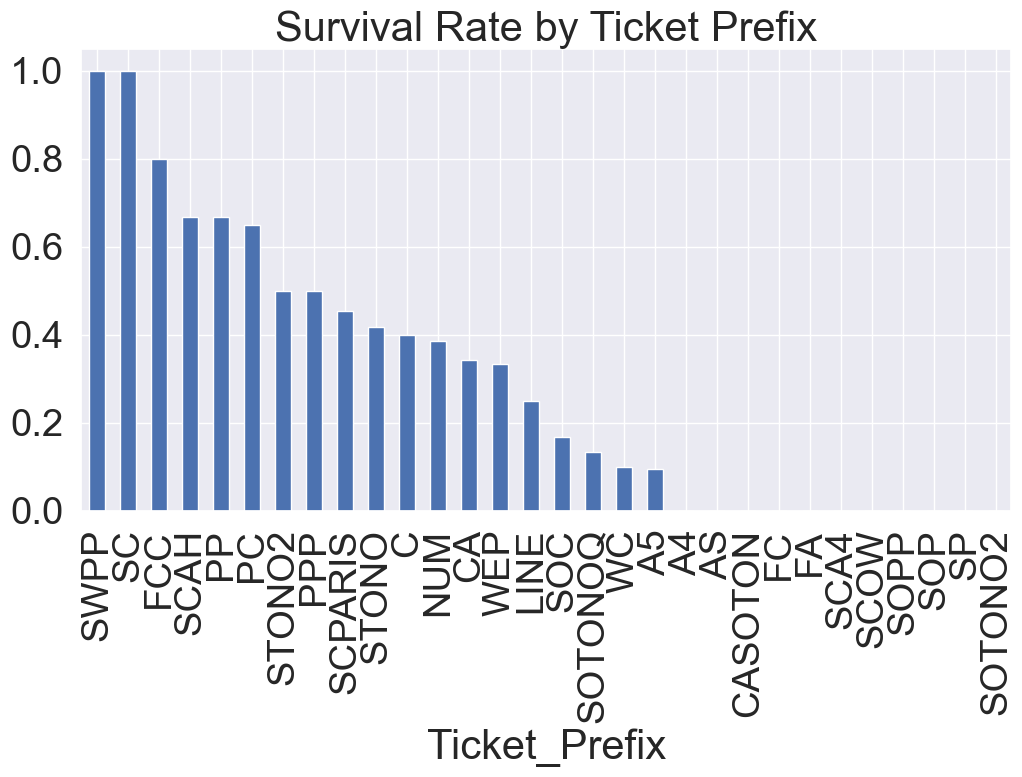

In [10]:
# train_processed 데이터프레임에 Survived와 Ticket_Prefix가 있다고 가정

# 1. 각 Ticket_Prefix 그룹별 생존율 계산
train_survival_by_prefix = train.groupby('Ticket_Prefix')['Survived'].mean().sort_values(ascending=False)

print("--- Ticket Prefix별 생존율 ---")
print(train_survival_by_prefix)

# 2. 결과 시각화
train_survival_by_prefix.plot(kind='bar', figsize=(12, 6), title='Survival Rate by Ticket Prefix')
plt.show()

In [11]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# --- 이 부분은 이전 코드에서 이미 실행되었습니다 ---
# rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
# X_train, y_train ...
# -----------------------------------------------

all_age = all_data[all_data['Age'].notnull()].copy()
# print(all_age.describe())

# 4. RandomForestRegressor 모델 학습
# Age 예측 모델의 Feature(X)와 Target(Y)를 정의
# Age 예측 모델에 사용할 Feature 리스트: Age와 연관성이 높고 수치화된 변수 사용
age_features = ['Title_Encoded', 'Pclass', 'family_size', 'Sex_Encoded', 'Fare_log', 'Embarked_Encoded','is_alone']
X_train = all_age[age_features]
X_train = pd.concat([X_train, all_age[age_features]], axis=0)
y_train = all_age['Age']
y_train = pd.concat([y_train, all_age['Age']], axis=0)
print("--- GridSearchCV를 사용한 하이퍼파라미터 튜닝 시작 ---")

# 1. 튜닝할 기본 모델 객체 생성
# n_estimators=100은 유지하고, random_state=42로 고정합니다.
rf_base = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. 탐색할 하이퍼파라미터 그리드 정의
#    'max_depth'와 'min_samples_leaf'의 후보 값들을 리스트로 지정합니다.
param_grid = {
    'max_depth': [3, 5, 7, 10],  # 트리의 최대 깊이 (규제)
    'min_samples_leaf': [5, 10, 15, 20] # 리프 노드의 최소 샘플 수 (규제)
}
# 위 설정은 4 * 4 = 16개의 조합을 테스트합니다.
# 각 조합마다 5-fold 교차 검증(cv=5)을 하므로, 총 16 * 5 = 80번의 학습이 수행됩니다.

# 3. GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=rf_base,        # 1. 기본 모델
    param_grid=param_grid,    # 2. 파라미터 그리드
    cv=5,                     # 3. 교차 검증 폴드 수 (기존과 동일하게 5)
    scoring='r2',             # 4. 평가 지표 (R-squared)
    n_jobs=-1,                # 5. 사용 가능한 모든 CPU 코어 사용 (속도 향상)
    verbose=2                 # 6. 검색 과정을 자세히 출력
)

# 4. 그리드 서치 실행 (데이터로 학습)
#    X_train, y_train는 이전 코드에서 정의한 데이터입니다.
grid_search.fit(X_train, y_train)

# 5. 튜닝 결과 확인
print("\n--- GridSearchCV 튜닝 결과 ---")
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 파라미터일 때 CV R^2 평균 점수: {grid_search.best_score_:.4f}")

# 6. 최적의 모델(best_estimator_)로 과적합이 얼마나 해소되었는지 확인
#    grid_search.best_estimator_는 최적의 파라미터로 '전체 X_train' 데이터에
#    대해 다시 학습된 모델입니다.
best_rf_regressor = grid_search.best_estimator_

# 최적 모델의 '학습 데이터'에 대한 성능 확인
y_pred_best = best_rf_regressor.predict(X_train)
r2_train_best = r2_score(y_train, y_pred_best)

print("\n--- 과적합 해소 확인 ---")
print(f"  [기존 모델] 학습 R²: 0.7245 | CV R²: 0.2711 (Gap: {0.7245 - 0.2711:.4f})")
print(f"  [튜닝된 모델] 학습 R²: {r2_train_best:.4f} | CV R²: {grid_search.best_score_:.4f} (Gap: {r2_train_best - grid_search.best_score_:.4f})")

# MSE 및 MAE 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_train, y_pred_best)
mae = np.mean(np.abs(y_train - y_pred_best))

print("\n3. 추가 평가 지표:")
print(f"  - 평균 제곱 오차 (MSE): {mse:.2f}")
print(f"  - 평균 절대 오차 (MAE): {mae:.2f}")

--- GridSearchCV를 사용한 하이퍼파라미터 튜닝 시작 ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- GridSearchCV 튜닝 결과 ---
최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_leaf': 5}
최적 파라미터일 때 CV R^2 평균 점수: 0.5455

--- 과적합 해소 확인 ---
  [기존 모델] 학습 R²: 0.7245 | CV R²: 0.2711 (Gap: 0.4534)
  [튜닝된 모델] 학습 R²: 0.6249 | CV R²: 0.5455 (Gap: 0.0795)

3. 추가 평가 지표:
  - 평균 제곱 오차 (MSE): 77.84
  - 평균 절대 오차 (MAE): 6.72


In [12]:
# ======================================================================
# 5. 'Age' 결측치 예측 및 원본 데이터에 채우기
# ======================================================================
print("--- 3. 'Age' 결측치 예측 및 채우기 시작 ---")

# 5-1. 'Age'가 결측치인 데이터 추출
all_null_age = all_data[all_data['Age'].isnull()].copy()
#print(all_null_age.describe())

# 5-4. 예측에 사용할 피처(X) 준비
X_predict_train = all_null_age[age_features]
#print(X_predict_train.describe())

# 5-5. 최종 모델로 'Age' 예측
predicted_age_train = best_rf_regressor.predict(X_predict_train) # (주의) 이 코드를 연속해서 실행 시 오류 -> clear all output & Run All
print(predicted_age_train.size)

# 5-6. (최종) 원본 DataFrame의 결측치에 예측된 'Age' 값 채우기
# .loc[행 인덱서, 열 이름]을 사용하여 정확하게 값을 할당합니다.
all_data.loc[all_data['Age'].isnull(), 'Age'] = predicted_age_train

print("--- 4. 'Age' 결측치 채우기 완료 ---")
print("\n--- 최종 확인 ---")
print(f"all 데이터 'Age' 결측치 개수: {all_data['Age'].isnull().sum()}")

--- 3. 'Age' 결측치 예측 및 채우기 시작 ---
263
--- 4. 'Age' 결측치 채우기 완료 ---

--- 최종 확인 ---
all 데이터 'Age' 결측치 개수: 0


In [13]:
# train과 test에 age가 채워진 all_data 분배하기
train = all_data[all_data['Survived'].notnull()].copy()
test = all_data[all_data['Survived'].isnull()].copy()
test.drop('Survived', axis=1, inplace=True)
#print(test.describe())

print(f"loss percentage of missing values in train set\n{train.isnull().sum()}") # loss of missing values in train set
print(f"\nloss percentage of missing values in test set\n{test.isnull().sum()}") # loss of missing values in test set

loss percentage of missing values in train set
PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
Title                 0
Sex_Encoded           0
Embarked_Encoded      0
Title_Encoded         0
family_size           0
is_alone              0
Fare_log              0
Ticket_Prefix         0
dtype: int64

loss percentage of missing values in test set
PassengerId           0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               327
Embarked              0
Title                 0
Sex_Encoded           0
Embarked_Encoded      0
Title_Encoded         0
family_size           0
is_alone              0
Fare_

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# --- 이 코드는 'train'과 'test' 데이터프레임이 이미 로드되어 있고, ---
# --- 'Age' 결측치가 (이전 단계에서) 모두 채워졌다고 가정합니다. ---

# --- 1. SVM을 위한 피처 엔지니어링 ---

# Submission(제출)을 위해 test의 PassengerId를 저장해 둡니다.
test_passenger_id = test['PassengerId']

# y_train (정답)을 미리 분리합니다.
y_train = train['Survived']

# 나중에 원-핫 인코딩을 일관되게 적용하기 위해 train과 test를 잠시 합칩니다.
# 'Survived' 열은 예측 대상이므로 합치기 전에 train에서 제거합니다.
full_data = pd.concat([train.drop('Survived', axis=1), test], ignore_index=True)

# --- 2. 피처 선택 및 원-핫 인코딩 ---

# 모델에 사용할 피처 리스트
# (주의: 'Age'는 사용하고, 'Fare' 대신 'Fare_log'를 사용)
numerical_features = ['Age', 'family_size', 'Fare_log']
categorical_features = ['Sex', 'Pclass', 'Embarked', 'Title', 'is_alone','Ticket_Prefix']

# 불필요한 피처 제거
drop_cols = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare']
full_data_processed = full_data.drop(columns=drop_cols)
#print(full_data_processed.describe())


# (중요) 범주형 피처에 대해 원-핫 인코딩 수행
# pd.get_dummies는 문자열 피처를 자동으로 0과 1로 구성된 여러 열로 변환합니다.
# drop_first=True는 다중공선성 문제를 피하기 위해 첫 번째 카테고리를 제거합니다.
full_data_processed = pd.get_dummies(
    full_data_processed, 
    columns=categorical_features, 
    drop_first=True
)

# --- 3. 데이터 분리 및 (필수) 스케일링 ---

# 다시 train과 test로 분리합니다.
X_train = full_data_processed.iloc[:len(train)]
X_test = full_data_processed.iloc[len(train):]

# (필수) StandardScaler로 SVM을 위한 스케일링 수행
scaler = StandardScaler()

# Scaler는 *반드시* 'train' 데이터로만 'fit' 해야 합니다. (Data Leakage 방지)
scaler.fit(X_train)

# 'train'과 'test' 데이터 모두 'transform'을 적용합니다.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- 피처 엔지니어링 및 스케일링 완료 ---")
print(f"학습 데이터 형태: {X_train_scaled.shape}")
print(f"테스트 데이터 형태: {X_test_scaled.shape}")

#> **중요:** 스케일링은 SVM에서 선택이 아닌 **필수**입니다. 위 그림처럼, 스케일링을 하지 않으면 'Fare'같이 범위가 큰 피처가 결정 경계를 왜곡시켜 모델 성능이 크게 저하됩니다.
print("\n--- 4. SVM 하이퍼파라미터 튜닝 시작 ---")

# 4-1. 튜닝할 기본 모델 객체 생성
svc_base = SVC(kernel='rbf', random_state=42)

# 4-2. 탐색할 하이퍼파라미터 그리드 정의
# (주의: 탐색 범위를 넓게 잡으면 튜닝 시간이 매우 오래 걸릴 수 있습니다)
param_grid = {
    'C': [0.1, 1, 10, 100],            # 10의 거듭제곱으로 탐색
    'gamma': ['scale', 0.1, 0.01]  # 'scale'(권장옵션) 및 10의 거듭제곱
}

# 4-3. GridSearchCV 객체 생성
grid_search_svc = GridSearchCV(
    estimator=svc_base,       # 기본 모델
    param_grid=param_grid,    # 파라미터 그리드
    cv=5,                     # 5-fold 교차 검증
    scoring='accuracy',       # 평가 지표
    n_jobs=-1,                # 모든 CPU 코어 사용
    verbose=2                 # 튜닝 과정 출력
)

# 4-4. 튜닝 실행 (스케일링된 학습 데이터 사용)
grid_search_svc.fit(X_train_scaled, y_train)

# 4-5. 튜닝 결과 확인
print("\n--- 튜닝 결과 ---")
print(f"최적의 하이퍼파라미터: {grid_search_svc.best_params_}")
print(f"최적 파라미터일 때 CV 정확도 (평균): {grid_search_svc.best_score_:.4f}")

# 4-6. 최적의 모델을 최종 모델로 사용
# GridSearchCV는 'refit=True'가 기본값이므로,
# 최적의 파라미터로 '전체 X_train_scaled' 데이터에 대해
# 자동으로 다시 학습된 모델을 'best_estimator_'로 제공합니다.
best_svc_model = grid_search_svc.best_estimator_

# ======================================================================
# --- 5. 예측 및 제출 파일 생성 --- (수정됨)
# ======================================================================

print("\n--- 5. 예측 및 제출 파일 생성 ---")

# 5-1. (수정) 튜닝된 최적의 모델(best_svc_model)로 예측
predictions = best_svc_model.predict(X_test_scaled)
predictions_int = predictions.astype(int)

# 5-2. 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': predictions_int
})

# 5-3. CSV 파일로 저장 (이름 변경)
submission.to_csv('svm_tuned_submission25_11_12.csv', index=False)

print("\n--- 'svm_tuned_submission.csv' 파일 생성 완료 ---")

--- 피처 엔지니어링 및 스케일링 완료 ---
학습 데이터 형태: (891, 51)
테스트 데이터 형태: (418, 51)

--- 4. SVM 하이퍼파라미터 튜닝 시작 ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- 튜닝 결과 ---
최적의 하이퍼파라미터: {'C': 1, 'gamma': 'scale'}
최적 파라미터일 때 CV 정확도 (평균): 0.8092

--- 5. 예측 및 제출 파일 생성 ---

--- 'svm_tuned_submission.csv' 파일 생성 완료 ---
